# MultiForest optimization notebook

## MSc Ilmari: New EU Forest Strategy 2030; Central Finland

Above the code cells, there are short instructions how the users can modify the codes in the cells.<br>
If there are no instructions, no changes should be needed for the cell by default.

A detailed description is provided in the <b>README.md</b> (https://github.com/maeehart/MultiForestDemonstration#readme)

## Basic definitions

Simulated forest data (climate scenario and name); sample size of data 

In [1]:
RCP = "rcp45" # "rcp0" = no climate change, "rcp45"
filename = "sample_central_fin_"+RCP+".zip" # sample_central_fin_rcp0.zip

Specify policy scenario: 
* "EUFS" - EU Forest Strategy 2030

In [2]:
scenario = "EUFS" 

Name definition for saved output, rule: _scenario_RCP_extension

In [3]:
extension = "V2woF" # some additional info to the saved output 

## Read .py class

In [4]:
import wget
import os
import pandas as pd
import sys
import numpy as np

In [5]:
import multiFunctionalOptimization as MFO

In [6]:
from importlib import reload
reload(MFO)

<module 'multiFunctionalOptimization' from '/home/ubuntu/workspace/opt_ilmari/multiFunctionalOptimization.py'>

If no solver is specified, the open source solver CLP is used

In [7]:
mfo = MFO.MultiFunctionalOptimization(solver = 'CPLEX') 

'Using CPLEX'

## Read data

In [8]:
%%time
mfo.readData(filename,
             sampleRatio=1 #If no sample ratio given, the ratio is assumed to be 1.
            )                

CPU times: user 4.47 s, sys: 2.01 s, total: 6.48 s
Wall time: 6.48 s


In [9]:
id = mfo.data.id

def get_unique_numbers(numbers):

    list_of_unique_numbers = []

    unique_numbers = set(numbers)

    for number in unique_numbers:
        list_of_unique_numbers.append(number)

    return list_of_unique_numbers

id = get_unique_numbers(id)
id = pd.DataFrame(id)
id.to_csv("./id_1.csv")

### TEST - REMOVE Fertilization regimes

In [10]:
indexNames = mfo.data[(mfo.data[mfo.regimesEnu] == 'BAUwoT_m20_F') | 
                      (mfo.data[mfo.regimesEnu] == 'BAU_m5_F') | 
                      (mfo.data[mfo.regimesEnu] == 'BAU_F') |
                      (mfo.data[mfo.regimesEnu] == 'BAUwT_F') | 
                      (mfo.data[mfo.regimesEnu] == 'BAUwT_m5_F')].index 
mfo.data.drop(indexNames, inplace = True)

In [11]:
mfo.data[mfo.regimesEnu].value_counts()

SA               71580
CCF_1            66760
BAUwoT_m20       66600
BAU_m5           66580
CCF_2            66520
BAUwoT           66500
BAU              66500
BAUwGTR          66500
BAU_5            66280
CCF_3            65760
BAU_15           64700
CCF_4            63760
BAU_30           56720
BAUwT_30         44420
BAUwT_5          44420
BAUwT_GTR        44420
BAUwT_m5         44420
BAUwT            44420
BAUwT_15         44420
BAUwT_5_B        28800
BAUwT_15_B       28800
BAUwT_GTR_B      28800
BAUwT_B          28800
BAUwT_30_B       28800
initial_state     3579
Name: regime, dtype: int64

## Create some new variables in the data

Calculate total (per stand) values from relative values:
* "Relative to Area" = simulated indicator value relate to one hectar -> scaled to represented area of NFI plot <br>
* ("Relative to volume" = indicator relates to standing Volume -> scaled to the represented volume of the plot) <br>
* ("Absolute Value" = takes the inticator value as it is)

In [12]:
columnTypes = {
    'i_Vm3':(float,"Relative to Area"),
    'Harvested_V':(float,"Relative to Area"),
    'Harvested_V_log_under_bark':(float,"Relative to Area"), 
    'Harvested_V_pulp_under_bark':(float,"Relative to Area"),
    'Harvested_V_under_bark':(float,"Relative to Area"), 
    'Biomass':(float,"Relative to Area"),
    'ALL_MARKETED_MUSHROOMS':(float,"Relative to Area"), 
    'BILBERRY':(float,"Relative to Area"), 
    'COWBERRY':(float,"Relative to Area"),
    'HSI_MOOSE':(float,"Relative to Area"),
    'CAPERCAILLIE':(float,"Relative to Area"), 
    'HAZEL_GROUSE':(float,"Relative to Area"), 
    'V_total_deadwood':(float,"Relative to Area"), 
    'N_where_D_gt_40':(float,"Relative to Area"),
    'prc_V_deciduous':(float,"Relative to Area"),
    'CARBON_SINK':(float,"Relative to Area"), 
    'Recreation':(float,"Relative to Area"),
    'Scenic':(float,"Relative to Area")
}

In [13]:
mfo.calculateTotalValuesFromRelativeValues(columnTypes=columnTypes)

List the new created columns: <br>
* Total_... hectare value multiplied by represented area (or volume)

In [14]:
[name for name in mfo.data.columns if "Total_" in name and "Relative" not in name]

['Total_i_Vm3',
 'Total_Harvested_V',
 'Total_Harvested_V_log_under_bark',
 'Total_Harvested_V_pulp_under_bark',
 'Total_Harvested_V_under_bark',
 'Total_Biomass',
 'Total_ALL_MARKETED_MUSHROOMS',
 'Total_BILBERRY',
 'Total_COWBERRY',
 'Total_HSI_MOOSE',
 'Total_CAPERCAILLIE',
 'Total_HAZEL_GROUSE',
 'Total_V_total_deadwood',
 'Total_N_where_D_gt_40',
 'Total_prc_V_deciduous',
 'Total_CARBON_SINK',
 'Total_Recreation',
 'Total_Scenic']

## Create new column
1) Column indicating if regime is "CCF_3, CCF_4, BAUwGTR" (TRUE/FLASE) <br>
Important for FES Biodiversity, allowed regimes for conservation sites.

2) Column indicating if regime is "SA" (TRUE/FALSE)<br>
Important for FES Biodiversity, allowed regimes for statutory protection sites.

3) Column indicating if regime is "BAUwT_B, BAUwT_5_B, BAUwT_15_B, BAUwT_30_B, BAUwT_GTR_B" <br>
Important for FES Resillience, allowed regimes for climate change adaption.

In [15]:
regimeClassNames = {"regimeClass0name":"CCF",
                    "regimeClass1name":"SA",
                    "regimeClass2name":"Broadleave"}
regimeClassregimes = {"regimeClass0regimes":["CCF_3","CCF_4","BAUwGTR", "BAUwT_GTR"],
                      "regimeClass1regimes":["SA"],
                      "regimeClass2regimes":["BAUwT_B", "BAUwT_5_B", "BAUwT_15_B", "BAUwT_30_B", "BAUwT_GTR_B"]}

In [16]:
mfo.addRegimeClassifications(regimeClassNames = regimeClassNames,regimeClassregimes=regimeClassregimes)

### % of stands falling in strictly protected areas

In [17]:
# Number of all stands
# len(mfo.data["id"].unique())
standid = mfo.data.drop_duplicates(['id'])
len(standid)

3579

In [18]:
len(standid[(standid["protection"] == "strict")]) / len(standid) * 100

2.7102542609667504

### % of stands only with set aside (incl. strictly protected & other unmanaged)

In [19]:
managed = mfo.data[(mfo.data["regime"] != "SA") & (mfo.data["regime"] != "initial_state")]
not_managed = mfo.data[(mfo.data["regime"] == "SA") ]

( len(not_managed["id"].unique()) - len(managed["id"].unique()) ) / len(not_managed["id"].unique()) * 100

5.588153115395362

### Define primary/old forest for additional protection

In [20]:
mfo.data['MAIN_SP'].unique()

array([2, 0, 3, 4, 1, 6, 9, 5, 8])

In [21]:
# value>1 Pinus sylvestris
# value>2 Picea abies
# value>3 Betula pendula
# value>4 Betula pubescens
# value>5 Populus tremula
# value>6 Alnus incana
# value>7 Alnus glutinosa<
# value>8 other coniferous tree species
# value>9 other decidious tree species

list_conifer = [1,2,8]
list_broadleave = [3,4,5,6,7,9]

In [22]:
# column indicating if old forest AND if regime SA
mfo.data['Old_forests'] = np.where(
    (mfo.data['AGE_ba'] >= 90) & (mfo.data['MAIN_SP'].isin(list_conifer) & (mfo.data['SA_forests'] == True) & (mfo.data['protection'] != "strict")) |
    (mfo.data['AGE_ba'] >= 90) & (mfo.data['MAIN_SP'].isin(list_broadleave) & (mfo.data['SA_forests'] == True) & (mfo.data['protection'] != "strict"))
        , True, False
)

In [23]:
#test = pd.DataFrame(mfo.data)
#test.to_csv("./test.csv")

In [24]:
#list(mfo.data.columns)

## Define initial value
1) Define initial values, recognized by the regime "initial_state", which only occurs at the first year (here 2016)

2) Create new variables that describe the <b>relative change to initial situation (start year) "Relative_"</b>:

In [25]:
mfo.finalizeData(initialRegime="initial_state")

New variables created:

In [26]:
[name for name in mfo.data.columns if "Relative_" in name]

['Relative_V',
 'Relative_Age',
 'Relative_AGE_ba',
 'Relative_ALL_MARKETED_MUSHROOMS',
 'Relative_BILBERRY',
 'Relative_COWBERRY',
 'Relative_HSI_MOOSE',
 'Relative_CAPERCAILLIE',
 'Relative_HAZEL_GROUSE',
 'Relative_V_total_deadwood',
 'Relative_N_where_D_gt_40',
 'Relative_prc_V_deciduous',
 'Relative_CARBON_STORAGE_Update',
 'Relative_Recreation',
 'Relative_Scenic',
 'Relative_Total_ALL_MARKETED_MUSHROOMS',
 'Relative_Total_BILBERRY',
 'Relative_Total_COWBERRY',
 'Relative_Total_HSI_MOOSE',
 'Relative_Total_CAPERCAILLIE',
 'Relative_Total_HAZEL_GROUSE',
 'Relative_Total_V_total_deadwood',
 'Relative_Total_N_where_D_gt_40',
 'Relative_Total_prc_V_deciduous',
 'Relative_Total_Recreation',
 'Relative_Total_Scenic']

In [27]:
mfo.data.head()

V  i_Vm3  Harvested_V  Harvested_V_log_under_bark  \
id       year regime                                                           
99011012 2021 BAU     113.94  10.59          0.0                         0.0   
              BAU_15  113.94  10.59          0.0                         0.0   
              BAU_30  113.94  10.59          0.0                         0.0   
              BAU_5   113.94  10.59          0.0                         0.0   
              BAU_m5  113.94  10.59          0.0                         0.0   

                      Harvested_V_pulp_under_bark  Harvested_V_under_bark  \
id       year regime                                                        
99011012 2021 BAU                             0.0                     0.0   
              BAU_15                          0.0                     0.0   
              BAU_30                          0.0                     0.0   
              BAU_5                           0.0                     0.0   
              BAU_m5                          0.0                     0.0   

                      MAIN_SP   Age  AGE_ba  SC  ...  Relative_Total_BILBERRY  \
id       year regime                             ...                            
99011012 2021 BAU           3  24.0   29.26   2  ...                 0.000124   
              BAU_15        3  24.0   29.26   2  ...                 0.000124   
              BAU_30        3  24.0   29.26   2  ...                 0.000124   
              BAU_5         3  24.0   29.26   2  ...                 0.000124   
              BAU_m5        3  24.0   29.26   2  ...                 0.000124   

                      Relative_Total_COWBERRY  Relative_Total_HSI_MOOSE  \
id       year regime                                                      
99011012 2021 BAU                    0.000225                       0.0   
              BAU_15                 0.000225                       0.0   
              BAU_30                 0.000225                       0.0   
              BAU_5                  0.000225                       0.0   
              BAU_m5                 0.000225                       0.0   

                      Relative_Total_CAPERCAILLIE  \
id       year regime                                
99011012 2021 BAU                             0.0   
              BAU_15                          0.0   
              BAU_30                          0.0   
              BAU_5                           0.0   
              BAU_m5                          0.0   

                      Relative_Total_HAZEL_GROUSE  \
id       year regime                                
99011012 2021 BAU                             0.0   
              BAU_15                          0.0   
              BAU_30                          0.0   
              BAU_5                           0.0   
              BAU_m5                          0.0   

                      Relative_Total_V_total_deadwood  \
id       year regime                                    
99011012 2021 BAU                            0.000308   
              BAU_15                         0.000308   
              BAU_30                         0.000308   
              BAU_5                          0.000308   
              BAU_m5                         0.000308   

                      Relative_Total_N_where_D_gt_40  \
id       year regime                                   
99011012 2021 BAU                                0.0   
              BAU_15                             0.0   
              BAU_30                             0.0   
              BAU_5                              0.0   
              BAU_m5                             0.0   

                      Relative_Total_prc_V_deciduous  \
id       year regime                                   
99011012 2021 BAU                           0.000776   
              BAU_15                        0.000776   
              BAU_30                        0.000776   
              B

In [28]:
mfo.initialData.head()

,,,V,i_Vm3,Harvested_V,Harvested_V_log_under_bark,Harvested_V_pulp_under_bark,Harvested_V_under_bark,MAIN_SP,Age,AGE_ba,SC,...,Total_V_total_deadwood,Total_N_where_D_gt_40,Total_prc_V_deciduous,Total_CARBON_SINK,Total_Recreation,Total_Scenic,CCF_forests,SA_forests,Broadleave_forests,Old_forests
id,year,regime,,,,,,,,,,,,,,,,,,,,,
99011012,2016,initial_state,64.83,0.0,0.0,0.0,0.0,0.0,3,16.0,26.86,2,...,1508.60,0.0,26996.0,0.0,1915.525,1424.833,False,False,False,False
99011013,2016,initial_state,27.12,0.0,0.0,0.0,0.0,0.0,2,15.0,14.92,2,...,1508.60,0.0,4764.0,0.0,1818.260,1428.406,False,False,False,False
99011014,2016,initial_state,374.02,0.0,0.0,0.0,0.0,0.0,2,80.0,79.48,1,...,1496.69,0.0,1191.0,0.0,2503.879,2317.289,False,False,False,False
99011015,2016,initial_state,4.19,0.0,0.0,0.0,0.0,0.0,2,11.0,9.42,2,...,1496.69,0.0,12307.0,0.0,1565.371,1272.385,False,False,False,False
99011016,2016,initial_state,141.85,0.0,0.0,0.0,0.0,0.0,1,89.0,71.71,4,...,1417.29,0.0,5161.0,0.0,2374.854,2432.816,False,False,False,False


## Define the optimization problem for policy scenarios
See README.md for details.

<b>Objective format:</b>

Unique_key :[Long human readable name, column name in data, max/min objective, year wise aggregation, stand wise aggregation (, target year )]

1) "Unique_key" : [ (2) "Long human readable name", (3) "column name", (4) "max/min objective", (5) "year wise aggregation", (6) "stand wise aggregation" (, (7) target year ) ]

<b>Options for "objective":</b> "max"imise or "min"imise it <br>
<b>year wise aggregation:</b> "min" (minimum value), "average", "firstYear", "targetYearWithSlope","targetYear","lastYear" <br>
<b>stand wise aggregation:</b> "sum", "areaWeightedAverage", "areaWeightedSum" <br>
<b>targe yeart:</b> any year except the first one

### EUFS - EU Forest Strategy 2030 - V1

In [29]:
if scenario == 'EUFS':
    
    biodiversity = {
    # Conservation regimes - overall target of 10%
    "Ratio_SA_forests": ["Ratio of protected areas (%, SA forests)",
                         "SA_forests","max","firstYear","areaWeightedAverage"],    
        
    # Additional strictly protected areas (on top of minimum possible for Ratio of protected areas)
    "Ratio_strictly_protected": ["Ratio of additional strictly protected forest (%, set aside)",
                          "Old_forests","max","firstYear","areaWeightedAverage"],  
        
    # Protection regimes "effective management" - target of 20%
    "Ratio_protection_regimes": ["Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)",
                          "CCF_forests","max","firstYear","areaWeightedAverage"],
        
    # Deadwood - maximise the deadwood in the protection regimes (could also be Age, or large living trees?)
    #"Total_Deadwood_V": ["Maximise deadwood in protected areas (m3)", 
    #                     "V_total_deadwood","max","min","subsetSum","CCF_forests"],
        
    # Large trees - maximise the large trees in the protection regimes
    "Total_Large_trees": ["Maximise large trees in protected areas (m3)", 
                          "Total_N_where_D_gt_40","max","min","subsetSum","CCF_forests"],
    
    # Deadwood - maximise over all forest
    "Avg_Deadwood_V": ["Average deadwood volume (m3/ha)", 
                       "V_total_deadwood","max","min","areaWeightedAverage"] , 

    # Deciduous trees (% of volume)
    "Avg_prc_V_deciduous":  ["Share of deciduous trees (% of standing volume)", 
                             "prc_V_deciduous","max", "min","areaWeightedAverage"]  
    }
    
    wood_production = { 
    # Harvested roundwood
    "Avg_Harvested_V" : ["Average harvested timber volume (log & pulp) (m3/ha, evenflow)",
                             "Harvested_V",
                             "max","min","areaWeightedAverage"] #,
    
    # Increment
    #"Avg_i_Vm3": ["Average timber volume increment(m3/ha)",
    #                  "i_Vm3","max","min","areaWeightedAverage"]
    }
    
    bioenergy = { 
    # Harvested biomass
    "Avg_Biomass": ["Average harvested biomass volume (m3/ha, evenflow)",
                    "Biomass", "max","min","areaWeightedAverage"]
    }
    
    climate_regulation = {
    # Carbon sink
    "Total_CARBON_SINK": ["Sequestration in carbon dioxide (t CO2)",
                          "CARBON_SINK","max","min","areaWeightedSum"] 
    }
    
    nonwood = {
    # Recreation index 
    "Total_Recreation" : ["Recreation index (max minimum over yrs)",
                          "Recreation","max","min","areaWeightedSum"],
        
    # Scenic index - maximise
    "Total_Scenic" : ["Scenic index (max minimum over yrs)",
                      "Scenic", "max","min","areaWeightedSum"],   
        
    # Bilberry - no decline, maximise it
    "Avg_BILBERRY": ["Average Bilberry yield (kg/ha)",
                     "BILBERRY","max","min","areaWeightedAverage"],
    
    # Cowberry - no decline, maximise it
    "Avg_COWBERRY": ["Average Cowberry yield (kg/ha)",
                     "COWBERRY","max","min","areaWeightedAverage"],
    
    # Mushrooms - no decline, maximise it
    "Avg_ALL_MARKETED_MUSHROOMS": ["Average mushroom yield (kg/ha)",
                                   "ALL_MARKETED_MUSHROOMS","max","min","areaWeightedAverage"]
    
    }

    objectives = {
              **biodiversity,
              **wood_production,
              **bioenergy,
              **climate_regulation ,
              **nonwood,
    }
    
    print("objectives for EUFS loaded")

objectives for EUFS loaded


In [30]:
len(objectives)

14

In [31]:
objectives.keys()

dict_keys(['Ratio_SA_forests', 'Ratio_strictly_protected', 'Ratio_protection_regimes', 'Total_Large_trees', 'Avg_Deadwood_V', 'Avg_prc_V_deciduous', 'Avg_Harvested_V', 'Avg_Biomass', 'Total_CARBON_SINK', 'Total_Recreation', 'Total_Scenic', 'Avg_BILBERRY', 'Avg_COWBERRY', 'Avg_ALL_MARKETED_MUSHROOMS'])

In [32]:
mfo.data.columns

Index(['V', 'i_Vm3', 'Harvested_V', 'Harvested_V_log_under_bark',
       'Harvested_V_pulp_under_bark', 'Harvested_V_under_bark', 'MAIN_SP',
       'Age', 'AGE_ba', 'SC', 'Biomass', 'ALL_MARKETED_MUSHROOMS', 'BILBERRY',
       'COWBERRY', 'HSI_MOOSE', 'CAPERCAILLIE', 'HAZEL_GROUSE',
       'V_total_deadwood', 'N_where_D_gt_40', 'prc_V_deciduous', 'PEAT',
       'clearcut', 'CARBON_SINK', 'CARBON_STORAGE_Update', 'Recreation',
       'Scenic', 'scenario', 'represented_area_by_NFIplot', 'region',
       'NUTS2_GL', 'protection', 'Total_i_Vm3', 'Total_Harvested_V',
       'Total_Harvested_V_log_under_bark', 'Total_Harvested_V_pulp_under_bark',
       'Total_Harvested_V_under_bark', 'Total_Biomass',
       'Total_ALL_MARKETED_MUSHROOMS', 'Total_BILBERRY', 'Total_COWBERRY',
       'Total_HSI_MOOSE', 'Total_CAPERCAILLIE', 'Total_HAZEL_GROUSE',
       'Total_V_total_deadwood', 'Total_N_where_D_gt_40',
       'Total_prc_V_deciduous', 'Total_CARBON_SINK', 'Total_Recreation',
       'Total_Sceni

In [33]:
[(col,mfo.data.dtypes[col]) for col in mfo.data.columns if "prc" in col]

[('prc_V_deciduous', dtype('float64')),
 ('Total_prc_V_deciduous', dtype('float64')),
 ('Relative_prc_V_deciduous', dtype('float64')),
 ('Relative_Total_prc_V_deciduous', dtype('float64'))]

## Define initial values NOT available in data, but needed for objective

Examples are increment, harvests, biomass and carbon sink. They are required for the "targetYearWithSlope" objective, but values only occur after the first simulation period. National values are taken from the policy or forest statistics. 

<b>For the EU Forest Strategy scenario this might not be required.</b> 

In [34]:
#initialValues = {"Total_i_Vm3":107*10**6,               # value from National Forest Policy
#                 "Total_Harvested_V": 72.3*10**6,       # value from National Forest Policy
#                 "Total_Biomass": 2.9*10**6,            # value from National Forest Policy
#                 "Total_CARBON_SINK" : 34.1*10**6}      # value from National Forest Policy

In [35]:
# mfo.defineObjectives(objectives,initialValues = initialValues)
mfo.defineObjectives(objectives)

'Defining objectives'

'Aggregating stand wise'

100%|██████████| 14/14 [03:45<00:00, 16.12s/it]


'Aggregating year wise'

100%|██████████| 14/14 [00:00<00:00, 3469.64it/s]


'Objectives added'

## Define enabled constraints

<b>For the EU Forest Strategy scenario this might not be required. </b> OR it can be a different enabled constraint - maybe related to the protection targets. Let´s see how the policy table looks ... 

In [36]:
CCFregimes = [regime for regime in mfo.regimes if "CCF" in regime] + ["SA"]

In [37]:
CCFregimes

['CCF_1', 'CCF_2', 'CCF_3', 'CCF_4', 'SA']

Constraint format:
- Shortname: "constraint type","allowed regimes","human readable name",(regimes),"column in data")

In [38]:
constraintTypes = {"CCFonPeat":["Allowed regimes","Only CCF on peat lands",CCFregimes,"PEAT"]}

In [39]:
mfo.defineConstraints(constraintTypes)

## Calculate objective ranges
The ideal and anti-ideal solution for the individual objective functions.

In [40]:
%%time
mfo.calculateObjectiveRanges(debug=True)

'Calculating objective ranges'

  0%|          | 0/14 [00:00<?, ?it/s]

'Optimizing for Ratio of protected areas (%, SA forests)'

'Found an optimal solution in 2 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.999999999999941

'Ratio of additional strictly protected forest (%, set aside)'

0.0718077675328302

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.0

'Maximise large trees in protected areas (m3)'

0.0

'Average deadwood volume (m3/ha)'

6.61401788208995

'Share of deciduous trees (% of standing volume)'

8.966191673651839

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

0.0

'Average harvested biomass volume (m3/ha, evenflow)'

0.0

'Sequestration in carbon dioxide (t CO2)'

2968686.6000000006

'Recreation index (max minimum over yrs)'

7477525.172000002

'Scenic index (max minimum over yrs)'

6916146.528000002

'Average Bilberry yield (kg/ha)'

6.347596814752738

'Average Cowberry yield (kg/ha)'

26.921031573065118

'Average mushroom yield (kg/ha)'

12.716789606035217

  7%|▋         | 1/14 [00:14<03:11, 14.70s/it]

'Optimizing for Ratio of additional strictly protected forest (%, set aside)'

'Found an optimal solution in 1 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.1260128527521651

'Ratio of additional strictly protected forest (%, set aside)'

0.0718077675328302

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.0

'Maximise large trees in protected areas (m3)'

0.0

'Average deadwood volume (m3/ha)'

4.7126962838781585

'Share of deciduous trees (% of standing volume)'

3.3143336127410135

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

1.4115423302598489

'Average harvested biomass volume (m3/ha, evenflow)'

0.23773120983514942

'Sequestration in carbon dioxide (t CO2)'

-1101928.464650001

'Recreation index (max minimum over yrs)'

7081144.888999987

'Scenic index (max minimum over yrs)'

6423816.902999994

'Average Bilberry yield (kg/ha)'

3.4462679519418877

'Average Cowberry yield (kg/ha)'

38.23084213467452

'Average mushroom yield (kg/ha)'

17.465420508521802

 14%|█▍        | 2/14 [00:28<02:53, 14.46s/it]

'Optimizing for Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

'Found an optimal solution in 1 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.05588153115395347

'Ratio of additional strictly protected forest (%, set aside)'

0.0016764459346186086

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.9424420229113776

'Maximise large trees in protected areas (m3)'

12152.17

'Average deadwood volume (m3/ha)'

4.284045822855541

'Share of deciduous trees (% of standing volume)'

3.155909471919559

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

1.566423582006146

'Average harvested biomass volume (m3/ha, evenflow)'

0.2537161218217379

'Sequestration in carbon dioxide (t CO2)'

-2715737.1766000036

'Recreation index (max minimum over yrs)'

6541249.502999983

'Scenic index (max minimum over yrs)'

5860616.42599999

'Average Bilberry yield (kg/ha)'

3.149859178541494

'Average Cowberry yield (kg/ha)'

42.250339200894146

'Average mushroom yield (kg/ha)'

17.88846605196958

 21%|██▏       | 3/14 [00:42<02:36, 14.19s/it]

'Optimizing for Maximise large trees in protected areas (m3)'

'Found an optimal solution in 1 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.05588153115395347

'Ratio of additional strictly protected forest (%, set aside)'

0.0016764459346186086

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.686504610226309

'Maximise large trees in protected areas (m3)'

34233.31

'Average deadwood volume (m3/ha)'

4.283945236099471

'Share of deciduous trees (% of standing volume)'

20.13449493389796

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

2.617241800855871

'Average harvested biomass volume (m3/ha, evenflow)'

0.006007264599050014

'Sequestration in carbon dioxide (t CO2)'

-2302795.812936846

'Recreation index (max minimum over yrs)'

6889336.546528933

'Scenic index (max minimum over yrs)'

6361563.232078415

'Average Bilberry yield (kg/ha)'

7.848523594505941

'Average Cowberry yield (kg/ha)'

34.75446229731915

'Average mushroom yield (kg/ha)'

14.798984348759557

 29%|██▊       | 4/14 [00:55<02:18, 13.85s/it]

'Optimizing for Average deadwood volume (m3/ha)'

'Found an optimal solution in 2 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.9555741827325547

'Ratio of additional strictly protected forest (%, set aside)'

0.0718077675328302

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.013970382788488386

'Maximise large trees in protected areas (m3)'

0.0

'Average deadwood volume (m3/ha)'

6.6155099189717665

'Share of deciduous trees (% of standing volume)'

10.040234702430752

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

0.0038250908074881247

'Average harvested biomass volume (m3/ha, evenflow)'

0.0006342553785973735

'Sequestration in carbon dioxide (t CO2)'

2735314.1199999945

'Recreation index (max minimum over yrs)'

7469091.303999998

'Scenic index (max minimum over yrs)'

6907376.798

'Average Bilberry yield (kg/ha)'

6.490530036322994

'Average Cowberry yield (kg/ha)'

27.36175579770881

'Average mushroom yield (kg/ha)'

12.803277451802183

 36%|███▌      | 5/14 [01:09<02:06, 14.01s/it]

'Optimizing for Share of deciduous trees (% of standing volume)'

'Found an optimal solution in 2 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.09360156468287205

'Ratio of additional strictly protected forest (%, set aside)'

0.003073484213467449

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.28122380553227994

'Maximise large trees in protected areas (m3)'

0.0

'Average deadwood volume (m3/ha)'

4.341276892986895

'Share of deciduous trees (% of standing volume)'

23.7457128387817

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

1.8335359038838037

'Average harvested biomass volume (m3/ha, evenflow)'

0.018172673931265714

'Sequestration in carbon dioxide (t CO2)'

-4597618.947550022

'Recreation index (max minimum over yrs)'

6897178.736437512

'Scenic index (max minimum over yrs)'

6383971.427312492

'Average Bilberry yield (kg/ha)'

7.453415872101134

'Average Cowberry yield (kg/ha)'

34.11236130902487

'Average mushroom yield (kg/ha)'

14.694872782201703

 43%|████▎     | 6/14 [01:23<01:51, 13.90s/it]

'Optimizing for Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

'Found an optimal solution in 2 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.05588153115395347

'Ratio of additional strictly protected forest (%, set aside)'

0.0016764459346186086

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.17419204047288595

'Maximise large trees in protected areas (m3)'

0.0

'Average deadwood volume (m3/ha)'

3.4126484105876793

'Share of deciduous trees (% of standing volume)'

17.05503322581227

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

5.787990468657745

'Average harvested biomass volume (m3/ha, evenflow)'

0.08389773679798826

'Sequestration in carbon dioxide (t CO2)'

1691209.9089403187

'Recreation index (max minimum over yrs)'

6811319.784238

'Scenic index (max minimum over yrs)'

6202969.108603026

'Average Bilberry yield (kg/ha)'

6.3119080364215225

'Average Cowberry yield (kg/ha)'

33.97948310576846

'Average mushroom yield (kg/ha)'

15.020095033336608

 50%|█████     | 7/14 [01:37<01:37, 13.89s/it]

'Optimizing for Average harvested biomass volume (m3/ha, evenflow)'

'Found an optimal solution in 2 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.05588153115395347

'Ratio of additional strictly protected forest (%, set aside)'

0.0016764459346186086

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.0005588153115395362

'Maximise large trees in protected areas (m3)'

0.0

'Average deadwood volume (m3/ha)'

2.6512304424563373

'Share of deciduous trees (% of standing volume)'

2.9847244342079295

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

3.8793553184250213

'Average harvested biomass volume (m3/ha, evenflow)'

0.7047570741828348

'Sequestration in carbon dioxide (t CO2)'

834746.3648423868

'Recreation index (max minimum over yrs)'

6646492.399786762

'Scenic index (max minimum over yrs)'

5980072.974194477

'Average Bilberry yield (kg/ha)'

3.6914382059481725

'Average Cowberry yield (kg/ha)'

39.83533206157606

'Average mushroom yield (kg/ha)'

17.925004232005335

 57%|█████▋    | 8/14 [01:51<01:23, 13.97s/it]

'Optimizing for Sequestration in carbon dioxide (t CO2)'

'Found an optimal solution in 3 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.5407087204992821

'Ratio of additional strictly protected forest (%, set aside)'

0.0235949301287227

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.07770715036063967

'Maximise large trees in protected areas (m3)'

0.0

'Average deadwood volume (m3/ha)'

5.220872866345539

'Share of deciduous trees (% of standing volume)'

6.45151136390995

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

0.009200894104498463

'Average harvested biomass volume (m3/ha, evenflow)'

0.0

'Sequestration in carbon dioxide (t CO2)'

9935691.194801226

'Recreation index (max minimum over yrs)'

7180988.528661261

'Scenic index (max minimum over yrs)'

6579016.776617381

'Average Bilberry yield (kg/ha)'

3.788138887071365

'Average Cowberry yield (kg/ha)'

26.132912230010323

'Average mushroom yield (kg/ha)'

16.20022733688666

 64%|██████▍   | 9/14 [02:07<01:12, 14.58s/it]

'Optimizing for Recreation index (max minimum over yrs)'

'Found an optimal solution in 2 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.5722253941219363

'Ratio of additional strictly protected forest (%, set aside)'

0.0368818105616093

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.019279128248113963

'Maximise large trees in protected areas (m3)'

0.0

'Average deadwood volume (m3/ha)'

5.486831148434732

'Share of deciduous trees (% of standing volume)'

10.544785532968858

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

1.2142581726739314

'Average harvested biomass volume (m3/ha, evenflow)'

0.08974573903324953

'Sequestration in carbon dioxide (t CO2)'

4729454.733833822

'Recreation index (max minimum over yrs)'

7578949.143999992

'Scenic index (max minimum over yrs)'

6893122.55941626

'Average Bilberry yield (kg/ha)'

5.451785303058339

'Average Cowberry yield (kg/ha)'

31.068603298050906

'Average mushroom yield (kg/ha)'

15.526183662645698

 71%|███████▏  | 10/14 [02:21<00:58, 14.60s/it]

'Optimizing for Scenic index (max minimum over yrs)'

'Found an optimal solution in 2 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.6502724458262064

'Ratio of additional strictly protected forest (%, set aside)'

0.03408773400391163

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.03408773400391163

'Maximise large trees in protected areas (m3)'

13970.429999999998

'Average deadwood volume (m3/ha)'

5.64731908821523

'Share of deciduous trees (% of standing volume)'

13.88107101907134

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

1.0614981203060878

'Average harvested biomass volume (m3/ha, evenflow)'

0.09712489522212898

'Sequestration in carbon dioxide (t CO2)'

2623675.34888779

'Recreation index (max minimum over yrs)'

7561654.832429445

'Scenic index (max minimum over yrs)'

6976913.5435826145

'Average Bilberry yield (kg/ha)'

6.676306130428266

'Average Cowberry yield (kg/ha)'

32.37842873450768

'Average mushroom yield (kg/ha)'

14.611640618210433

 79%|███████▊  | 11/14 [02:36<00:43, 14.55s/it]

'Optimizing for Average Bilberry yield (kg/ha)'

'Found an optimal solution in 3 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.2232467169600489

'Ratio of additional strictly protected forest (%, set aside)'

0.02347024308466047

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.36127409891032075

'Maximise large trees in protected areas (m3)'

0.0

'Average deadwood volume (m3/ha)'

4.724794635373014

'Share of deciduous trees (% of standing volume)'

20.122101145571325

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

2.067362391729534

'Average harvested biomass volume (m3/ha, evenflow)'

0.029860296172115112

'Sequestration in carbon dioxide (t CO2)'

1130980.1306500023

'Recreation index (max minimum over yrs)'

7198598.926999988

'Scenic index (max minimum over yrs)'

6624638.161999993

'Average Bilberry yield (kg/ha)'

8.497726459905

'Average Cowberry yield (kg/ha)'

32.92288823693774

'Average mushroom yield (kg/ha)'

14.256697401508688

 86%|████████▌ | 12/14 [02:51<00:29, 14.78s/it]

'Optimizing for Average Cowberry yield (kg/ha)'

'Found an optimal solution in 3 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.05588153115395347

'Ratio of additional strictly protected forest (%, set aside)'

0.0016764459346186086

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.026029412450687683

'Maximise large trees in protected areas (m3)'

0.0

'Average deadwood volume (m3/ha)'

2.82314916715712

'Share of deciduous trees (% of standing volume)'

4.64786299026291

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

2.590385785837599

'Average harvested biomass volume (m3/ha, evenflow)'

0.30851654026467396

'Sequestration in carbon dioxide (t CO2)'

-2626323.3428591928

'Recreation index (max minimum over yrs)'

6217613.5531619815

'Scenic index (max minimum over yrs)'

5546910.8146055285

'Average Bilberry yield (kg/ha)'

3.995789567633512

'Average Cowberry yield (kg/ha)'

48.6303979966456

'Average mushroom yield (kg/ha)'

16.97191684078717

 93%|█████████▎| 13/14 [03:07<00:15, 15.24s/it]

'Optimizing for Average mushroom yield (kg/ha)'

'Found an optimal solution in 6 seconds'

'Objective values are:'

'Ratio of protected areas (%, SA forests)'

0.14290741491231376

'Ratio of additional strictly protected forest (%, set aside)'

0.003073484213467449

'Ratio of forest under protection regimes (%, CCF_3, CCF_4 and BAUwGTR)'

0.019279128248113963

'Maximise large trees in protected areas (m3)'

0.0

'Average deadwood volume (m3/ha)'

3.9214542552046705

'Share of deciduous trees (% of standing volume)'

4.406108201466599

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

0.40091639429539183

'Average harvested biomass volume (m3/ha, evenflow)'

0.04554871402465238

'Sequestration in carbon dioxide (t CO2)'

-2734638.856908449

'Recreation index (max minimum over yrs)'

7027457.377792226

'Scenic index (max minimum over yrs)'

6331127.738473495

'Average Bilberry yield (kg/ha)'

2.9830008365265863

'Average Cowberry yield (kg/ha)'

37.472018903963935

'Average mushroom yield (kg/ha)'

19.22524688919624

100%|██████████| 14/14 [03:26<00:00, 14.78s/it]
CPU times: user 3min 10s, sys: 2min 58s, total: 6min 8s
Wall time: 3min 26s


In [41]:
mfo.objectiveRanges

{'Ratio_SA_forests': (0.05588153115395347, 0.999999999999941),
 'Ratio_strictly_protected': (0.0016764459346186086, 0.0718077675328302),
 'Ratio_protection_regimes': (0.0, 0.9424420229113776),
 'Total_Large_trees': (0.0, 34233.31),
 'Avg_Deadwood_V': (2.6512304424563373, 6.6155099189717665),
 'Avg_prc_V_deciduous': (2.9847244342079295, 23.7457128387817),
 'Avg_Harvested_V': (0.0, 5.787990468657745),
 'Avg_Biomass': (0.0, 0.7047570741828348),
 'Total_CARBON_SINK': (-4597618.947550022, 9935691.194801226),
 'Total_Recreation': (6217613.5531619815, 7578949.143999992),
 'Total_Scenic': (5546910.8146055285, 6976913.5435826145),
 'Avg_BILBERRY': (2.9830008365265863, 8.497726459905),
 'Avg_COWBERRY': (26.132912230010323, 48.6303979966456),
 'Avg_ALL_MARKETED_MUSHROOMS': (12.716789606035217, 19.22524688919624)}

## Show GUI

* If "Enabled constraints" should be considered, start with ticking box "only CCF ..." and push "Change constraints"
* Epsilon constraints are only considered if sliders are moved and button "Set epsilon constraints" is pushed
* By pushing "OPTIMIZE" an optimal solution under the given constraints and reference points is searched

In [42]:
mfo.showGUI(debug=True)

interactive(children=(FloatSlider(value=0.05588153115395347, description='Ratio of protected areas (%, SA fore…

interactive(children=(FloatSlider(value=0.5279407655769472, description='Ratio of protected areas (%, SA fores…

interactive(children=(Checkbox(value=False, description='Only CCF on peat lands'), Button(description='Change …

Button(description='Print solution', style=ButtonStyle())

## Visualization of optimal solution

In [43]:
regimeAmounts = {regime:0 for regime in mfo.regimes}
for key in mfo.regimesDecision.keys():
    regimeAmounts[key[1]] +=mfo.regimesDecision[key].solution_value()*mfo.standAreas.loc[key[0],"represented_area_by_NFIplot"]/mfo.standAreas["represented_area_by_NFIplot"].sum()

In [44]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [45]:
#[val for val in regimeAmounts.values()]

<IPython.core.display.Javascript object>


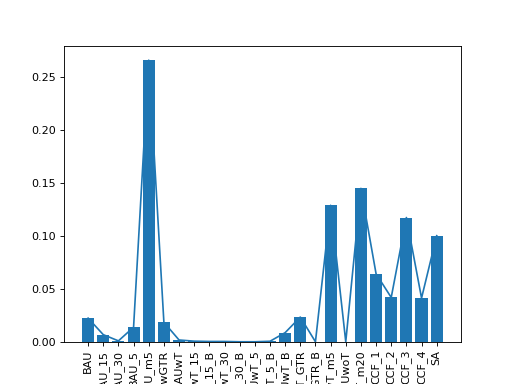

In [46]:
plt.plot([key for key in regimeAmounts.keys()],[val for val in regimeAmounts.values()])

In [47]:
plt.bar(range(len(regimeAmounts)), list(regimeAmounts.values()), align='center')
plt.xticks(range(len(regimeAmounts)), list(regimeAmounts.keys()),rotation="vertical")

([<matplotlib.axis.XTick at 0x7f8daf9e16a0>,
 [Text(0, 0, 'BAU'),
  Text(0, 0, 'BAU_15'),
  Text(0, 0, 'BAU_30'),
  Text(0, 0, 'BAU_5'),
  Text(0, 0, 'BAU_m5'),
  Text(0, 0, 'BAUwGTR'),
  Text(0, 0, 'BAUwT'),
  Text(0, 0, 'BAUwT_15'),
  Text(0, 0, 'BAUwT_15_B'),
  Text(0, 0, 'BAUwT_30'),
  Text(0, 0, 'BAUwT_30_B'),
  Text(0, 0, 'BAUwT_5'),
  Text(0, 0, 'BAUwT_5_B'),
  Text(0, 0, 'BAUwT_B'),
  Text(0, 0, 'BAUwT_GTR'),
  Text(0, 0, 'BAUwT_GTR_B'),
  Text(0, 0, 'BAUwT_m5'),
  Text(0, 0, 'BAUwoT'),
  Text(0, 0, 'BAUwoT_m20'),
  Text(0, 0, 'CCF_1'),
  Text(0, 0, 'CCF_2'),
  Text(0, 0, 'CCF_3'),
  Text(0, 0, 'CCF_4'),
  Text(0, 0, 'SA')])

## Export data as csv

- <b>Solution_alldata</b> contains the optimal regime per stand AND the timely development of indicator values plus all other input columns (represented_are_by_NFIplot, region, NUTS2)
- <b>Solution</b> contains only the selected optimal regime and its share (if multiple regimes per stand are selected)


In [48]:
try:
    os.mkdir("results")
except FileExistsError:
    pass
b = []
c = []
for key in mfo.regimesDecision.keys():
    if mfo.regimesDecision[key].solution_value() > 0:
        b = b+ [(key[0],x*5+2016, key[1]) for x in range(0,21)]
        c = c+ [(key[0],key[1],mfo.regimesDecision[key].solution_value())]
data2b = mfo.data.iloc[mfo.data.index.isin(b)]
data2b.to_csv("./results/solutionAlldata_"+scenario+"_"+RCP+"_"+extension+".csv")
c1 = pd.DataFrame(c)
c1.to_csv("./results/solution_"+scenario+"_"+RCP+"_"+extension+".csv")

## Export objective ranges 

Save as json file

In [49]:
import json
mfo.objectiveRanges

with open('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.json', 'w') as json_file:
  json.dump(mfo.objectiveRanges, json_file)

Save as CSV.

In [50]:
df = pd.read_json('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.json')

df.to_csv('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.csv')

## Export objective values
The optimal solution for each objective.

In [51]:
with open("./results/objectiveValues_"+scenario+'_'+RCP+'_'+extension+".csv","w") as file: 
    delim = "" 
    for objName in mfo.objectiveTypes.keys(): 
        file.write(delim+objName) 
        delim = "," 
    file.write("\n") 
    delim = "" 
    for objName in mfo.objectiveTypes.keys(): 
        file.write(delim+str(mfo.objective[objName].solution_value())) 
        delim = "," 
    file.write("\n")